 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch import distributions, optim
from sklearn.metrics import mean_squared_error

In [2]:
'''from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\n%cd /content/drive/MyDrive/GitHub/master-thesis\n\nimport sys\nsys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')"

In [3]:
%cd ..

/home/anuarsantoyo/PycharmProjects/master-thesis


In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *
from clustering.utils import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 7
# Overall Time Period
start_time='2020-09-15' # Mitte November/ Anfang Dezember bis Februar Before: '2020-08-01'
end_time='2020-12-01'#'2021-02-01''2020-12-01'
test_end_time='2021-02-01' # Begin Vaccination Wave

# TODO: Mitte september Anfang, split 01.12.20 end 01.02.21


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Training
df_obs_test, initial_newly_infected_test = initialize_observations(df_obs_initial, start=start_time, end=test_end_time, rolling_avg=rolling_avg_obs)
observed_train_test = df_obs_test[observation]

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-09-15,0.857143,345.428571,13.142857
1,2020-09-16,0.857143,382.000000,14.285714
2,2020-09-17,0.857143,403.285714,14.142857


# Experiment Settings

In [7]:
method_type = 'linear'
#method_type = 'nn'

input_type = 'factor_data'
#input_type = 'group_data'
#input_type = 'mobility_data'

# Load Input Data

In [8]:
if input_type == 'factor_data':
  input_data_cols = ['F0_cautious_behaviour','F1_perception_advice' ,'F2_applicability_usefullness_advice' , 'F3_behaviour_others','F4_consequence_advice']#]#
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input.csv', rolling_avg=1, input_data_cols=input_data_cols)

elif input_type == 'group_data':
  input_data_cols = ''
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/group_percentage_non_careful.csv', rolling_avg=7, input_data_cols=None)
elif input_type == 'mobility_data':
  input_data_cols = ['google_workplaces', 'google_residential', 'google_transit'] #['apple_driving', 'apple_walking', 'apple', 'google_retail', 'google_grocery', 'google_workplaces', 'google_residential', 'google_transit', 'google', 'telco', 'applegoogle']
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=input_data_cols)
input_data_size = input_data.shape[1]
input_data_size

5

In [9]:
#df_mob = pd.read_csv('data/modeling/mobility_data.csv')
#df_mob.date = pd.to_datetime(df_mob.date, format='%Y-%m-%d')
#df_mob = df_mob[df_mob['region'] == 'denmark'].reset_index(drop=True)
#df_mob.drop(columns=['region'], inplace=True)
#df_mob.to_csv('data/modeling/mobility_data_denmark.csv', index=False)
#df_mob.head()

## Initialize Model Parameter

### Initialize helper parameter

In [10]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [11]:
if method_type == 'linear':
  method = Linear(device=device, dtype=dtype, input_size=input_data_size)
  
elif method_type == 'nn':
  method = NN(device=device, dtype=dtype, input_size=input_data_size)

### Initialize alpha and phi

In [12]:
exp_parameters = pd.read_csv('data/modeling/experiments_estimated_parameters.csv', index_col=0)

In [13]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
#dict_param['real_values']['alpha'] = torch.tensor(exp_parameters.describe()['alpha']['50%'], requires_grad=False, device=device, dtype=dtype)
#dict_param['real_values']['phi'] = torch.tensor(exp_parameters.describe()['phi']['50%'], requires_grad=False, device=device, dtype=dtype)
dict_param

{'prime_values': {'alpha': tensor(-3.5835, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

# Optimization

## Test Optimization

In [13]:
from tqdm.auto import tqdm

plot = False
#[['F0_cautious_behaviour'],['F1_perception_advice'] ,['F2_applicability_usefullness_advice'] , ['F3_behaviour_others'],['F4_consequence_advice']]
#[['google_workplaces'], ['google_residential'], ['google_transit']]
#[None]
factor_info = dict()
for factor in tqdm([['google_workplaces'], ['google_residential'], ['google_transit']], desc=f'Factors', leave=True):

    #torch.manual_seed(42)
    _input_data = get_model_input(start=start_time, end=test_end_time, split_date=end_time, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=factor)
    input_data = _input_data[0]

    test_input_data = np.concatenate((_input_data[0], _input_data[1]), axis=0)

    input_data_size = input_data.shape[1]


    meta_epoch_params = {}
    loss_development = {}
    meta_epoch_pred = {}
    meta_epoch_pred_test = {}
    meta_epoch_test_mse = {}

    for meta_epoch in tqdm(range(100), desc=f'Meta Epochs', leave=False):
        #method = NN(device=device, dtype=dtype, input_size=input_data_size)
        method = Linear(device=device, dtype=dtype, input_size=input_data_size)

        dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)

        params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi'], dict_param['prime_values']['alpha']]
        optimizer = optim.Adam(params_to_be_optimized, lr=0.01)

        loss_development[meta_epoch] = []

        if plot:
            with torch.no_grad():
                print(f'{factor} Before Optimization')
                print(f'Metha epoch: {meta_epoch}\n'
                      f'Linear Factors: {method.get_parameters()[0].detach().numpy()}\n',
                      f'Bias: {method.get_parameters()[1].detach().numpy()}\n',
                      f'Alpha: {dict_param["real_values"]["alpha"]}\n',
                      f'Phi: {dict_param["real_values"]["phi"]}\n')

        for i in tqdm(range(1, 1000), desc='epochs', leave=False):
            iteration_time = time.time()
            optimizer.zero_grad()

            # transform alphi, phi
            dict_param = transform_prime_variables(dict_param)

            # forward pass
            expected = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

            # calc loss
            comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
            method_loss = method.calculate_loss()
            model_param_loss = calc_prior_loss(dict_param, device, dtype)
            loss = comparison_loss_train + method_loss + model_param_loss

            loss_development[meta_epoch].append(loss.item())

            # backward pass
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                if params_to_be_optimized[1].grad.detach().numpy()[0] == 0:
                    print('Gradient is zero')
                    break

        if params_to_be_optimized[1].grad.detach().numpy()[0] == 0:
            del loss_development[meta_epoch]
            continue
        else:
            with torch.no_grad():
                expected_test = epid_model(R=method.calculate_R(test_input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

                meta_epoch_params[meta_epoch] = {'lin_params': method.get_parameters(),'loss': loss,'alpha': dict_param["real_values"]["alpha"].detach().numpy(),'phi': dict_param["real_values"]["phi"].detach().numpy()}

                meta_epoch_pred[meta_epoch] = expected.cpu().detach().numpy()
                meta_epoch_pred_test[meta_epoch] = expected_test.cpu().detach().numpy()
                test_size = _input_data[1].shape[0]
                meta_epoch_test_mse[meta_epoch] = mean_squared_error(expected_test.cpu().detach().numpy()[-test_size:], observed_train_test[-test_size:].reset_index(drop=True))

                if plot:
                    print('normal')
                    plt.plot(expected_test.cpu().detach().numpy())
                    plt.plot(observed_train_test)
                    plt.show()

                    print('tail')
                    plt.plot(expected_test.cpu().detach().numpy()[-test_size:])
                    plt.plot(observed_train_test[-test_size:].reset_index(drop=True))
                    plt.show()





        if plot:
            with torch.no_grad():

                meta_epoch_params[meta_epoch] = (method.get_parameters(), loss, dict_param["real_values"]["alpha"].detach().numpy(), dict_param["real_values"]["phi"].detach().numpy())
                print('After Optimization')
                print(f'Metha epoch: {meta_epoch}\n'
                      f'Linear Factors: {method.get_parameters()[0].detach().numpy()}\n',
                      f'Bias: {method.get_parameters()[1].detach().numpy()}\n',
                      f'Alpha: {dict_param["real_values"]["alpha"]}\n',
                      f'Phi: {dict_param["real_values"]["phi"]}')


                plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
                plt.plot(df_obs['Date'], observed_train.cpu().detach().numpy(), label='observed')
                plt.legend()
                plt.show()
                plt.plot()


    factor_info[str(factor)] = {'meta_epoch_params': meta_epoch_params, 'meta_epoch_pred': meta_epoch_pred,'meta_epoch_pred_test': meta_epoch_pred_test, 'loss_development': loss_development, 'meta_epoch_test_mse':meta_epoch_test_mse}



Factors:   0%|          | 0/3 [00:00<?, ?it/s]

Meta Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


Meta Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


Meta Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

Gradient is zero


epochs:   0%|          | 0/999 [00:00<?, ?it/s]

In [14]:
import _pickle as cPickle

with open(r"data/modeling/split_tests/split_test_50_new/linear_mobility50_new.pickle", "wb") as output_file:
    cPickle.dump(factor_info, output_file)

['google_workplaces']


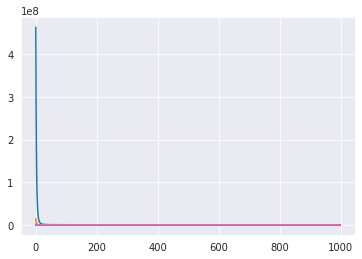

['google_residential']


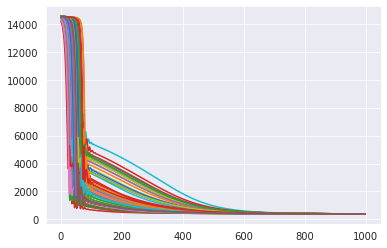

['google_transit']


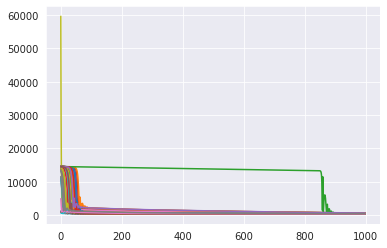

In [30]:
for key in factor_info.keys():
    print(key)
    for i in factor_info[key]['loss_development'].keys():
        try:
            plt.plot(factor_info[key]['loss_development'][i])
        except:
            pass
    plt.show()

In [31]:
f0 = [meta_epoch_params[i][0][0].detach().numpy()[0][0] for i in meta_epoch_params.keys()]
#f1 = [meta_epoch_params[i][0][0].detach().numpy()[0][1] for i in meta_epoch_params.keys()]
#f2 = [meta_epoch_params[i][0][0].detach().numpy()[0][2] for i in meta_epoch_params.keys()]
#f3 = [meta_epoch_params[i][0][0].detach().numpy()[0][3] for i in meta_epoch_params.keys()]
#f4 = [meta_epoch_params[i][0][0].detach().numpy()[0][4] for i in meta_epoch_params.keys()]
b = [meta_epoch_params[i][0][1].detach().numpy()[0] for i in meta_epoch_params.keys()]
alpha = [meta_epoch_params[i][2] for i in meta_epoch_params.keys()]
phi = [meta_epoch_params[i][3] for i in meta_epoch_params.keys()]
loss_param = [float(meta_epoch_params[i][1].detach().numpy()) for i in meta_epoch_params.keys()]

KeyError: 0

In [ ]:
params_dist_df = pd.DataFrame({'f0': f0, 'b': b, 'alpha': alpha, 'phi': phi, 'loss': loss_param})#, 'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4

In [ ]:
params_dist_df = params_dist_df[params_dist_df['loss']<20000]

In [ ]:
params_dist_df.boxplot(column=['f0', 'b'])#, 'f1', 'f2', 'f3', 'f4'
plt.show()